In [1]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.model_selection
from progressbar import progressbar
import torch

In [2]:
pd.options.display.float_format = '{:.6f}'.format

In [3]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y, X = y.astype(np.int64), X.reshape(-1, 784).astype(np.float32)
X[X < 128] = 0
X[X > 0] = 1
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=47)

In [4]:
EPOCHS=500
BATCH_SIZE=128

accuracy = lambda prediction, target: np.sum(np.argmax(prediction, axis=1) == target) / target.shape[0]
lossFn = torch.nn.CrossEntropyLoss()

model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.Tanh(),
    torch.nn.Linear(128, 10),
    torch.nn.Softmax(dim=1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [5]:
for epoch in progressbar(range(EPOCHS)):
    order = np.random.permutation(train_data.shape[0])
    train_x = train_data[order]
    train_y = train_target[order]
    for i in range(0, train_x.shape[0] // BATCH_SIZE):
        batch_x = train_x[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch_y = train_y[i*BATCH_SIZE:(i+1)*BATCH_SIZE]

        optimizer.zero_grad()
        output = model(torch.from_numpy(batch_x))
        loss = lossFn(output, torch.from_numpy(batch_y))
        loss.backward()
        optimizer.step()

100% (500 of 500) |######################| Elapsed Time: 0:06:39 Time:  0:06:390332


# Gradient based approach

In [6]:
BACKWARD_ITERS=1_000_000
DECAY_STEPS=35
model.eval()
for param in model.parameters():
    param.requires_grad = False
samples = torch.rand((10, 784), dtype=torch.float32, requires_grad=True)
samples_orig = samples.detach().numpy().copy()
sample_targets = torch.tensor([0,1,2,3,4,5,6,7,8,9])
sample_optimizer = torch.optim.SGD([samples], lr=20, momentum=0.9)
decay = torch.optim.lr_scheduler.StepLR(sample_optimizer, step_size=int(BACKWARD_ITERS / DECAY_STEPS), gamma=1/10 * DECAY_STEPS/5)
lossFn = torch.nn.CrossEntropyLoss()

In [7]:
losses = []
for i in progressbar(range(BACKWARD_ITERS)):
    samples.grad = None
    output = model(samples)
    loss = lossFn(output, sample_targets)
    loss.backward()
    sample_optimizer.step()
    losses.append(loss.item())
    decay.step()

100% (1000000 of 1000000) |##############| Elapsed Time: 0:11:16 Time:  0:11:160555


In [8]:
pd.DataFrame(output.detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.110968,0.000008,0.111088,0.111351,0.110899,0.111074,0.111244,0.111215,0.111194,0.110960
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


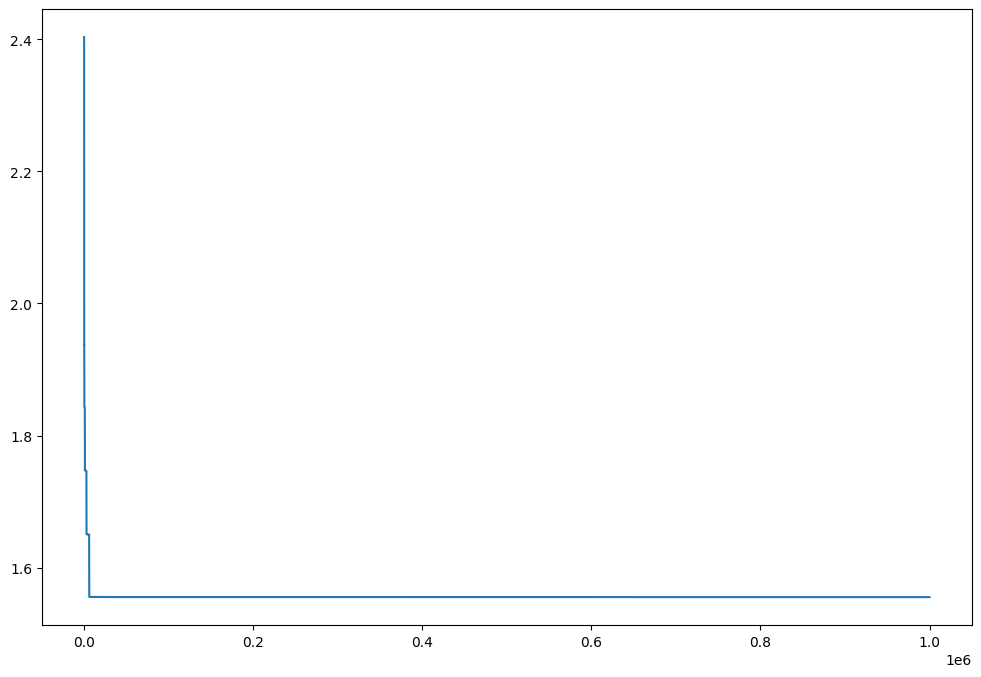

In [9]:
plt.figure(figsize=(12,8))
plt.plot(losses)
plt.show()

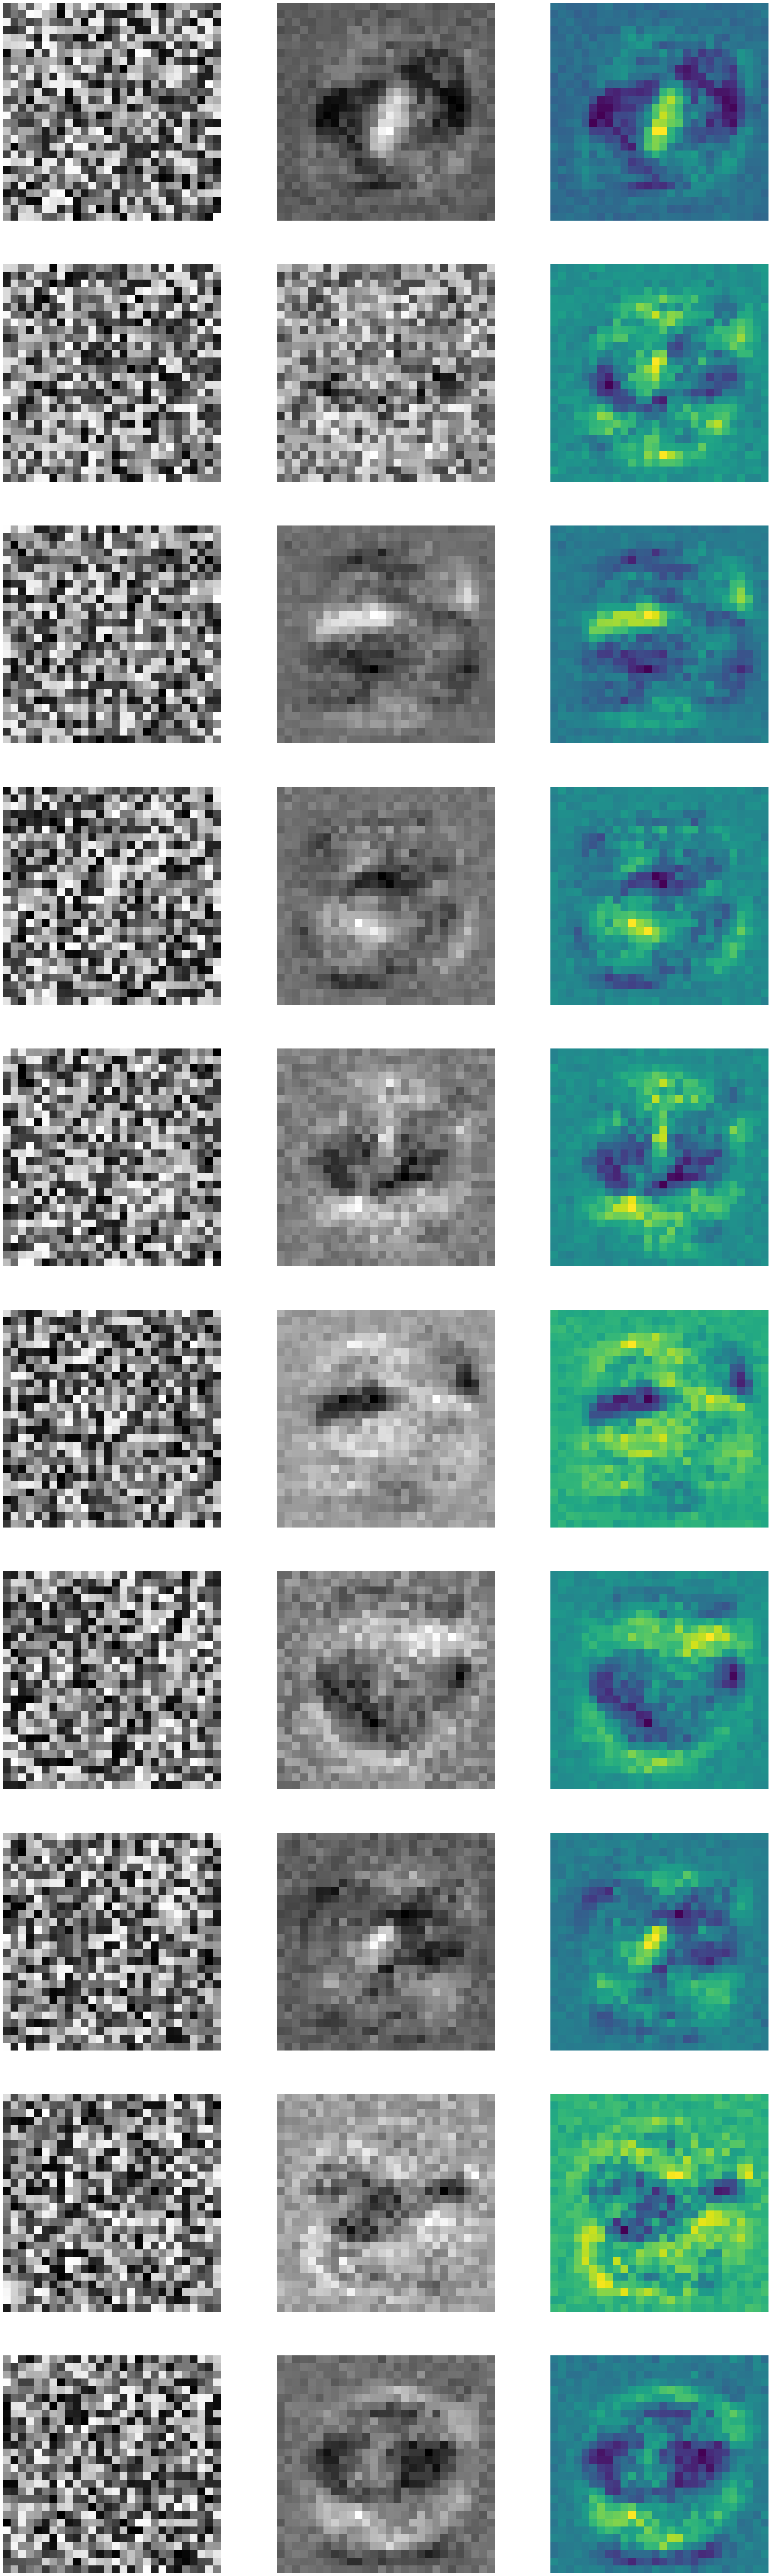

In [10]:
fig = plt.figure(figsize=(12 * 3, 12 * 10))
axes = fig.subplots(10, 3)
for i in range(10):
    orig = samples_orig[i].reshape((28,28))
    new = samples[i].detach().numpy().reshape((28,28))
    axes[i][0].imshow(orig, cmap='binary')
    axes[i][1].imshow(new, cmap='binary')
    axes[i][2].imshow(orig - new)
    for ax in axes[i]:
        ax.axis('off')

# Anneling approach

In [11]:
BACKWARD_ITERS=5_000_000
model.eval()
for param in model.parameters():
    param.requires_grad = False
samples = torch.rand((10, 784), dtype=torch.float32, requires_grad=True)
samples_orig = samples.detach().numpy().copy()
sample_targets = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
lossFn = torch.nn.CrossEntropyLoss(reduction='none')

In [12]:
with torch.no_grad():
    losses = []
    for i in progressbar(range(BACKWARD_ITERS)):
        current_anneal = 1.0 - 1.0 / BACKWARD_ITERS * i
        output = model(samples)
        current_loss = lossFn(output, sample_targets)
        agg_loss = current_loss.sum()
        losses.append(agg_loss.item())
        to_change = torch.randint(0, 784, (samples.shape[0],))
        change_val = torch.rand((samples.shape[0],))
        potential = samples.clone()
        potential[torch.arange(samples.shape[0]), to_change] = change_val
        new_loss = lossFn(model(potential), sample_targets)
        better_indexes = torch.argwhere(current_loss > new_loss).numpy()
        worse_indexes = torch.argwhere(current_loss >= new_loss).numpy()
        annealed = worse_indexes[np.argwhere(np.random.random(worse_indexes.shape) < current_anneal)]
        samples[better_indexes, :] = potential[better_indexes, :]
        samples[annealed, :] = potential[annealed, :]

100% (5000000 of 5000000) |##############| Elapsed Time: 1:11:38 Time:  1:11:383550


In [13]:
pd.DataFrame(output.detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.199430,0.000000,0.199796,0.200119,0.000000,0.200184,0.000001,0.000007,0.200387,0.000074
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.199966,0.000000,0.200155,0.200018,0.000000,0.199713,0.000010,0.000002,0.200133,0.000003
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


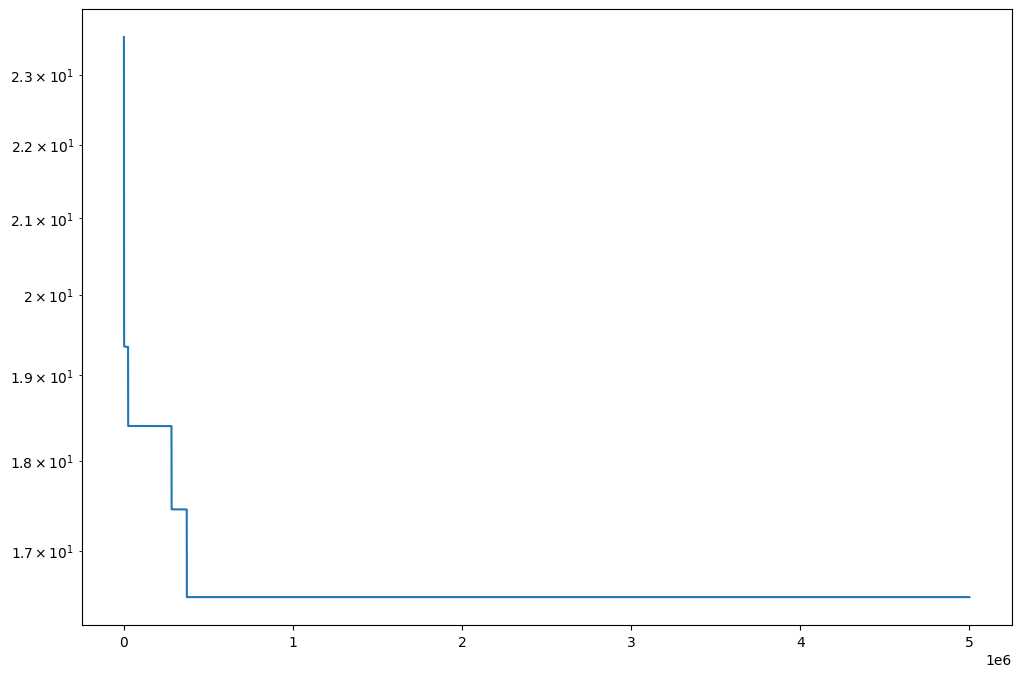

In [14]:
plt.figure(figsize=(12,8))
plt.plot(losses)
plt.yscale('log')
plt.show()

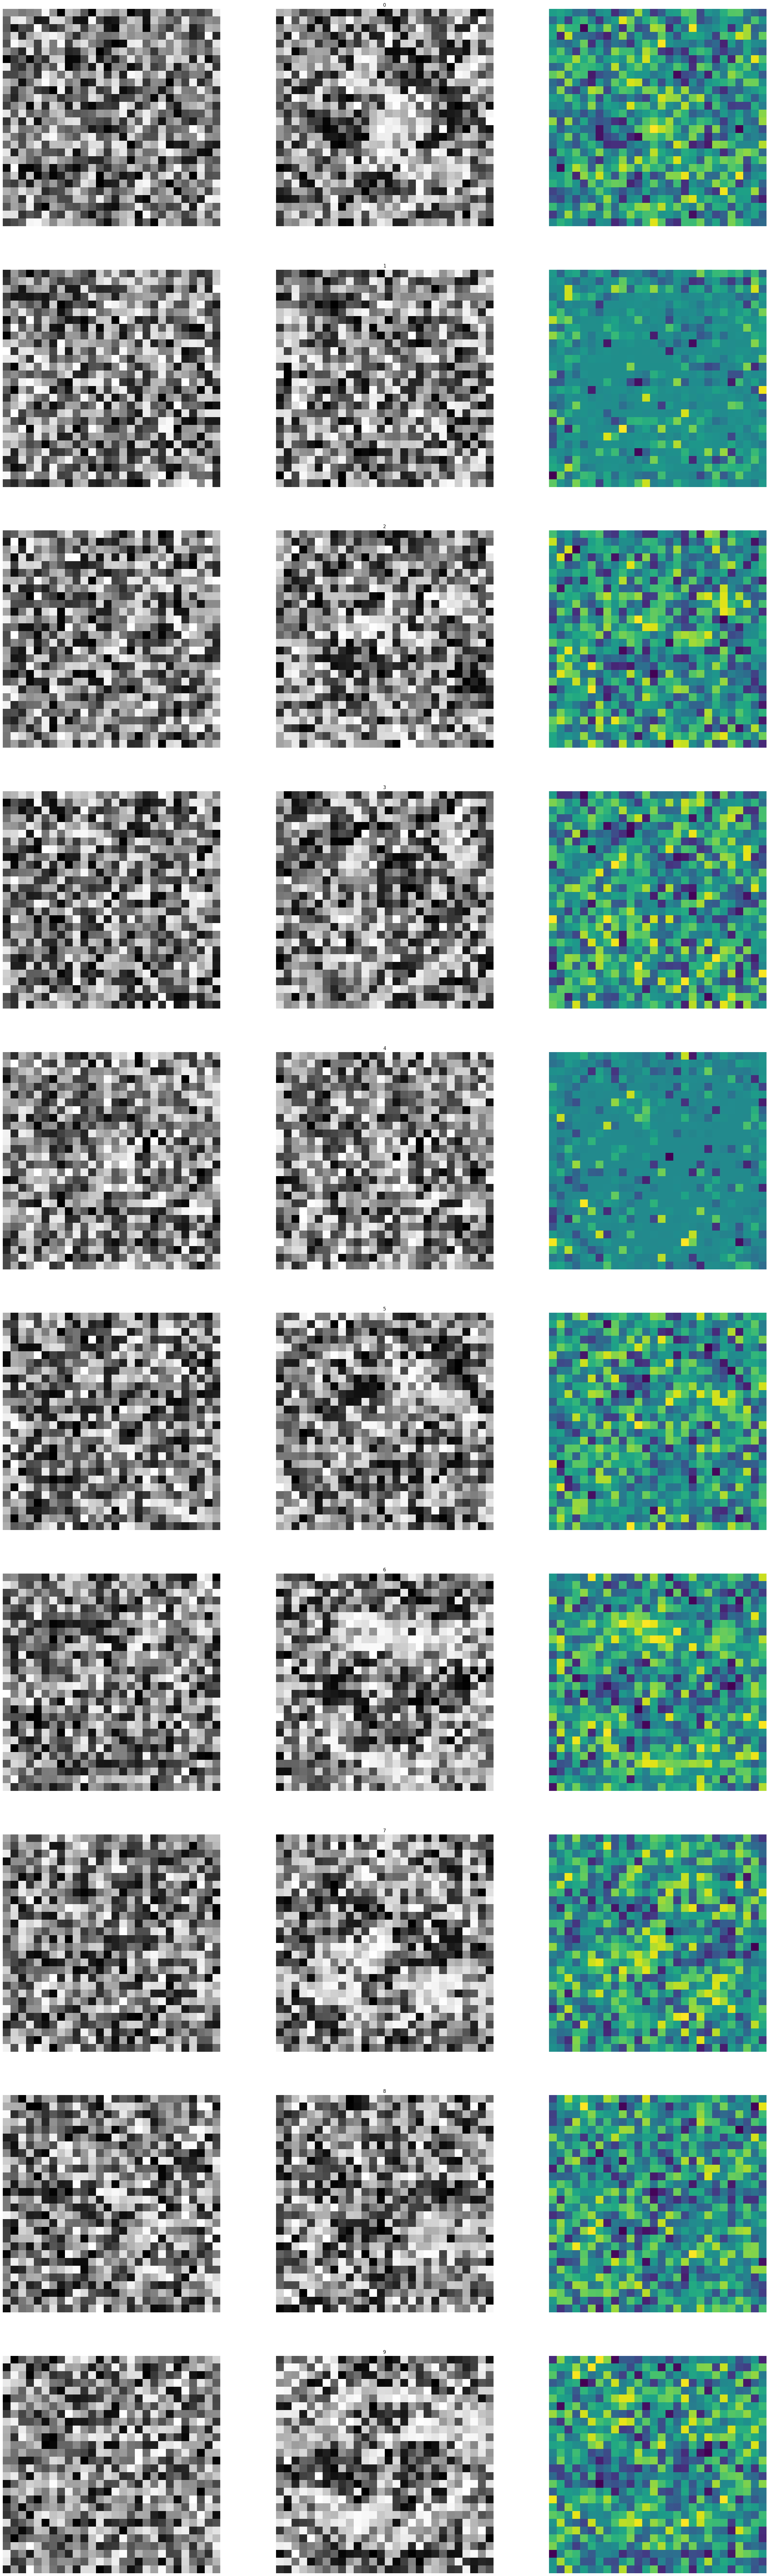

In [15]:
fig = plt.figure(figsize=(12 * 3, 12 * 10))
axes = fig.subplots(10, 3)
for i in range(10):
    orig = samples_orig[i].reshape((28,28))
    new = samples[i].detach().numpy().reshape((28,28))
    axes[i][1].title.set_text(str(i))
    axes[i][0].imshow(orig, cmap='binary')
    axes[i][1].imshow(new, cmap='binary')
    axes[i][2].imshow(orig - new)
    for ax in axes[i]:
        ax.axis('off')